<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parse-raw-data-to-2D-conc.-matrices,-a-source-vector,-a-time-vector-and-a-distance-vector,-and-put-these-in-their-own-folder" data-toc-modified-id="Parse-raw-data-to-2D-conc.-matrices,-a-source-vector,-a-time-vector-and-a-distance-vector,-and-put-these-in-their-own-folder-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parse raw data to 2D conc. matrices, a source vector, a time vector and a distance vector, and put these in their own folder</a></span></li><li><span><a href="#Find-RMS-minimizing-D-for-each-folder" data-toc-modified-id="Find-RMS-minimizing-D-for-each-folder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Find RMS-minimizing D for each folder</a></span></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot results</a></span></li></ul></div>

In [23]:
import convolution_solution as cs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

import pickle
from os import listdir
from glob import glob
from itertools import product
from tqdm import tqdm

In [24]:
rawdatafolder = "./MartinRasmussen_linerois_all/"
parseddatafolder = "./parseddata/"
resultsfolder = "./results/"

In [44]:
bestfolder = "./best_fit_models_arrays/"
a1left = "best_fit_model_a1_left.npy"

In [45]:
tmp = np.load(bestfolder + a1left)

In [46]:
tmp.shape

(5535, 10)

In [51]:
objfolder = "./obj/"
a1left = "d_solutions_increase_t_res_a1_left.pkl"

a1right = "d_solutions_increase_t_res_a1_right.pkl"
a3right = "d_solutions_increase_t_res_a3_right.pkl"

In [65]:
with open(objfolder + a3right, "rb") as f:
    tmp = pickle.load(f)

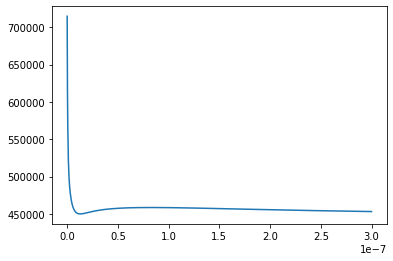

In [77]:
ks = np.array([k for k in tmp.keys()])
vs = np.array([v for v in tmp.values()])

plt.plot(ks, vs)

## Parse raw data to 2D conc. matrices, a source vector, a time vector and a distance vector, and put these in their own folder

In [16]:
def parseanimalside(
    rawfolder,
    parsedfolder,
    animalsidecombo,
    pixelsize_mm,
    frameduration_h,
    num_pixels_to_average_source_over,
):
    """ Turns raw data into parsed data (see definitions).
    
    Args:
        rawfolder: path
        parsedfolder: path
        animalsidecombo: string e.g. "a1_left_"
        pixelsize_mm: float
        framduration_h: float
    Returns:
        conc_matrix, source_vector, time_vector, distance_vector
    """
    
    sas_matrix = parse_to_matrix(rawfolder, animalsidecombo + "_sas")
    source_vector = sas_matrix[:, -num_pixels_to_average_source_over:].mean(axis=1)
    
    conc_matrix = parse_to_matrix(rawfolder, animalsidecombo + "_tg")
    #source_vector = conc_matrix[:, 0]
    #assert source_vector.size == conc_matrix.shape[0], f"source_vector.size, conc_matrix.shape[0] = {source_vector.size}, {conc_matrix.shape[0]}"

    num_frames, num_pixels = conc_matrix.shape
    source_vector = source_vector[:num_frames]
    time_vector = np.cumsum(num_frames * [frameduration_h,])
    distance_vector = np.cumsum(num_pixels * [pixelsize_mm,])
    
    assert distance_vector.size == num_pixels, f"(distance_vector.size, num_pixels) = ({distance_vector.size}, {num_pixels})"
    assert time_vector.size == num_frames
    assert time_vector.size == source_vector.size, f"(time_vector.size, source_vector.size) = ({time_vector.size}, {source_vector.size})"
    
    savetodir = parsedfolder + animalsidecombo + "/"
    np.save(savetodir + "source_vector", source_vector)
    np.save(savetodir + "concmatrix", conc_matrix)
    np.save(savetodir + "time_vector", time_vector)
    np.save(savetodir + "distance_vector", distance_vector)
    
    plt.plot(time_vector, conc_matrix[:, 0], label="conc matrix t=0")
    plt.plot(time_vector, source_vector, label="source vector")
    plt.legend()
    plt.title(animalsidecombo)
    plt.show()
    
    return conc_matrix, source_vector, time_vector, distance_vector

In [17]:
def switch_left_sastg(f):
    sas_or_tg = "sas" if "sas" in f else "tg"
    left_or_right = "left" if "left" in f else "right"
    
    sas_or_tg_last = True if f[-2:] == "as" or f[-2:] == "tg" else False
    
    if sas_or_tg_last:
        return f[:3] + sas_or_tg + "_" + left_or_right
    else:
        return f[:3] + left_or_right + "_" + sas_or_tg

In [18]:
def parse_to_matrix(
    rawfolder,
    basename,
):
    csv_files = [f for f in listdir(rawfolder)
                 if basename in f and ".csv" in f]
    if len(csv_files) == 0:
        csv_files = [f for f in listdir(rawfolder)
                     if basename in switch_left_sastg(f) and ".csv" in f]
        
        if len(csv_files) == 0:
            print(f"no CSV files found for {basename}")
            return np.nan * np.zeros((2, 2))
    
    def extract_framenum(filename):
        try:
            return int(filename[len(basename):].replace('.csv', ''))
        except ValueError as ve:
            print(filename)
            raise ve
        
    sorted_csv_files = sorted(csv_files, key=extract_framenum)

    raw_df_list = []
    for filename in sorted_csv_files:
        df = pd.read_csv(rawfolder + filename, )
        raw_df_list.append(df['Results'])

    conc_matrix_df = pd.concat(raw_df_list, axis=1, ignore_index=True)
    conc_matrix = np.transpose(conc_matrix_df.values)
    
    return conc_matrix

parsing a1_left... 


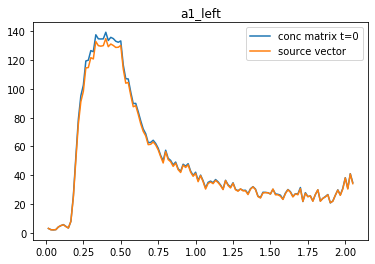

parsing a1_right... 


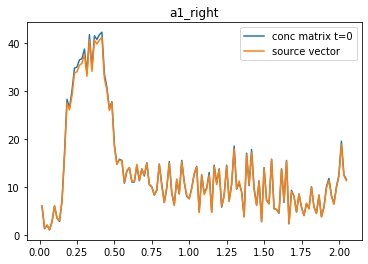

parsing a2_left... 


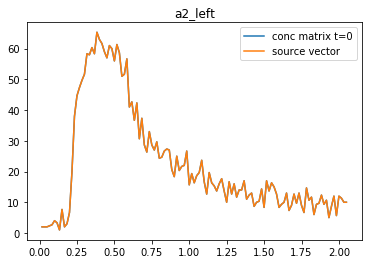

parsing a2_right... 


In [ ]:
animalsidecombos = ['_'.join(p) for p in product(["a1", "a2", "a3", "a4"], ["left", "right"])]

for animalsidecombo in animalsidecombos:
    print(f"parsing {animalsidecombo}... ")
    (conc_matrix, source_vector, time_vector,
     distance_vector) = parseanimalside(
        rawdatafolder,
        parseddatafolder,
        animalsidecombo,
        pixelsize_mm=0.078,
        frameduration_h=1.0/60.0,
        num_pixels_to_average_source_over=1,
    )

## Find RMS-minimizing D for each folder

In [343]:
def make_prediction_func(
    source_vector,
    conc_matrix,
    time_vector,
    distance_vector,
):
    diffusion_solution_func = cs.create_diff_eq_solution_function(source_vector, time_vector)
    
    prediction_matrix = np.nan * np.zeros_like(conc_matrix)
    
    def prediction_func(D_guess):
        for row_index in range(prediction_matrix.shape[0]):
            prediction_matrix[row_index, :] = diffusion_solution_func(
                distance_vector,
                time_vector[row_index],
                D_guess
            )
        
        return prediction_matrix
    
    return prediction_func

In [344]:
def make_error_function(
    source_vector,
    conc_matrix,
    time_vector,
    distance_vector,
    lam = 0.0,
):
    prediction_func = make_prediction_func(source_vector, conc_matrix, time_vector, distance_vector)
    
    def error_func(D_guess):
        prediction = prediction_func(D_guess)
        error = np.sqrt(np.mean(np.square(prediction - conc_matrix))) + lam * D_guess
        return error
    
    return error_func

In [377]:
def rollingmeandownsample(matrix_or_vector, windowsize):
    df = pd.DataFrame(matrix_or_vector)
    return df.rolling(windowsize).mean().values[::windowsize]

In [345]:
def find_RMS_minimizing_D_for_data_in_folder(folder, lam, subsampleskipsteps, maxiter):
    
    identifier = folder.split("/")[-1]
    
    source_vector = np.load(folder + "/source_vector.npz.npy")
    conc_matrix = np.load(folder + "/concmatrix.npz.npy")
    time_vector = np.load(folder + "/time_vector.npz.npy")
    distance_vector = np.load(folder + "/distance_vector.npz.npy")
    
    #source_vector_downsample = rollingmeandownsample(source_vector, subsampleskipsteps)
    #conc_matrix_downsample = rollingmeandownsample(conc_matrix, subsampleskipsteps)
    #time_vector_downsample = rollingmeandownsample(time_vector, subsampleskipsteps)
    source_vector = source_vector[::subsampleskipsteps]
    conc_matrix = conc_matrix[::subsampleskipsteps, :]
    time_vector = time_vector[::subsampleskipsteps]
    
    conc_timesteps, conc_distances = conc_matrix.shape
    assert distance_vector.size == conc_distances
    assert time_vector.size == conc_timesteps
    assert time_vector.size == source_vector.size
    
    error_func = make_error_function(
        source_vector_downsample,
        conc_matrix_downsample,
        time_vector_downsample,
        distance_vector,
        lam,
    )
    
    #minresult = minimize_scalar(
    #    error_func,
    #    bounds=(0.000001, np.Inf),
    #    method='bounded',
    #    options={'maxiter': maxiter},
    #)
    minresult = minimize_scalar(
        error_func,
    )
    best_D = minresult.x
    best_error = minresult.fun
    
    return best_D, best_error, identifier, minresult

In [371]:
resultsdict = dict()
minresults = []
lam = 0.01
subsampleskipsteps = 2
maxiter = 50

parsedfolders = glob(parseddatafolder + '*', recursive=True)

for folder in tqdm(parsedfolders):
    print("Finding best D for folder", folder, ". ", end="")
    
    try:
        D, RMS, identifier, minresult = find_RMS_minimizing_D_for_data_in_folder(
            folder,
            lam,
            subsampleskipsteps,
            maxiter
        )

        resultsdict[identifier] = (identifier, D, RMS)
        minresults.append(minresult)
        print("success: ", minresult.success)
        
    except ValueError as ve:
        print(ve)

resultsdf = pd.DataFrame.from_dict(resultsdict, orient='index', columns=["ID", "D", "error"])
resultsdf.to_csv(resultsfolder + f'results_with_lam_{lam}.csv', index=False)

  0%|          | 0/8 [00:00<?, ?it/s]/Volumes/GoogleDrive/My Drive/PhD/small tasks/Martin TG Diffusion/convolution_solution.py:34: RuntimeWarning: divide by zero encountered in true_divide
  num = x * np.exp(-np.square(x) / (4 * D * t))
/Volumes/GoogleDrive/My Drive/PhD/small tasks/Martin TG Diffusion/convolution_solution.py:37: RuntimeWarning: invalid value encountered in true_divide
  return num / denom


Finding best D for folder ./parseddata/a1_left . 

 12%|█▎        | 1/8 [10:42<1:14:55, 642.21s/it]

success:  True
Finding best D for folder ./parseddata/a1_right . 

 25%|██▌       | 2/8 [21:46<1:05:29, 654.97s/it]

success:  True
Finding best D for folder ./parseddata/a2_left . 

 38%|███▊      | 3/8 [30:44<50:07, 601.52s/it]  

success:  True
Finding best D for folder ./parseddata/a2_right . 

 50%|█████     | 4/8 [43:56<45:08, 677.05s/it]

success:  True
Finding best D for folder ./parseddata/a3_left . 

 62%|██████▎   | 5/8 [54:20<32:53, 657.67s/it]

success:  True
Finding best D for folder ./parseddata/a4_right . 

 75%|███████▌  | 6/8 [1:05:37<22:08, 664.37s/it]

success:  True
Finding best D for folder ./parseddata/a3_right . 

 88%|████████▊ | 7/8 [1:16:30<11:00, 660.65s/it]

success:  True
Finding best D for folder ./parseddata/a4_left . 

100%|██████████| 8/8 [1:27:05<00:00, 653.25s/it]

success:  True


## Plot results

In [372]:
resultsdf

,ID,D,error
a1_left,a1_left,0.094499,15.975316
a1_right,a1_right,0.278124,3.863768
a2_left,a2_left,0.234955,6.245297
a2_right,a2_right,0.061482,15.387995
a3_left,a3_left,0.062424,11.353151
a4_right,a4_right,0.075373,6.625584
a3_right,a3_right,0.192609,3.346901
a4_left,a4_left,0.071085,15.324073


In [373]:
def plot_compare_data_prediction(folder, identifier, D_guess, subsampleskipsteps, saveto):
        
    source_vector = np.load(folder + "/source_vector.npz.npy")
    conc_matrix = np.load(folder + "/concmatrix.npz.npy")
    time_vector = np.load(folder + "/time_vector.npz.npy")
    distance_vector = np.load(folder + "/distance_vector.npz.npy")
    
    source_vector = source_vector[0::subsampleskipsteps]
    conc_matrix = conc_matrix[0::subsampleskipsteps, :]
    time_vector = time_vector[0::subsampleskipsteps]

    prediction_func = make_prediction_func(
        source_vector,
        conc_matrix,
        time_vector,
        distance_vector,
    )
    
    prediction = prediction_func(D_guess)
    
    num_rois = conc_matrix.shape[1]
    #for i in range(num_rois):
    #plt.plot(time_vector, source_vector, label="source")
    #plt.plot(time_vector, prediction[:, 0], linestyle=':', label="pred")
    #plt.plot(time_vector, conc_matrix[:, 0], linestyle='-.', label="data")
    #plt.legend()
    #plt.show()
    
    fig, axes = plt.subplots(num_rois, 1, sharex=True, figsize=(6, 12))
    for i, ax in enumerate(axes):
        axes[i].plot(time_vector, conc_matrix[:, i], marker='o', label="data")
        axes[i].plot(time_vector, prediction[:, i], label="prediction")
    
    axes[0].legend()
    axes[-1].set_xlabel("time (h)")
    axes[0].set_ylabel("conc.")
    axes[0].set_title(identifier)
    plt.savefig(saveto, bbox_inches='tight')
    
    plt.show()

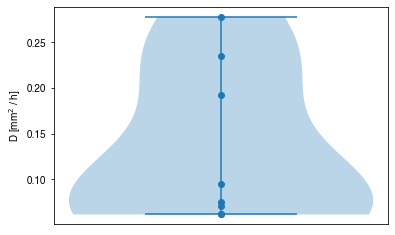

In [374]:
plt.violinplot(resultsdf["D"], positions=[1,])
plt.scatter(np.ones_like(resultsdf["D"]), resultsdf["D"])

plt.xticks([])
plt.ylabel("D [mm$^2$ / h]")

plt.show()

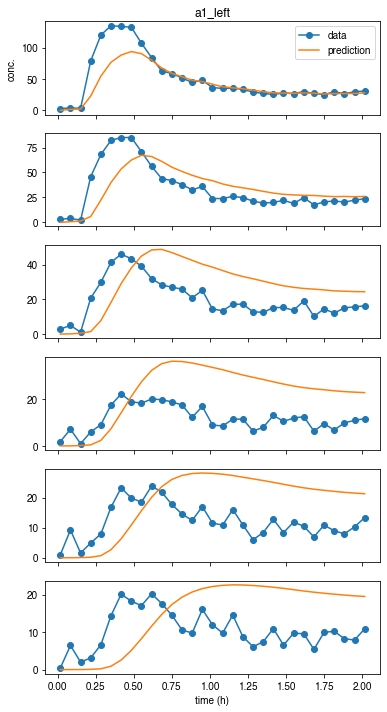

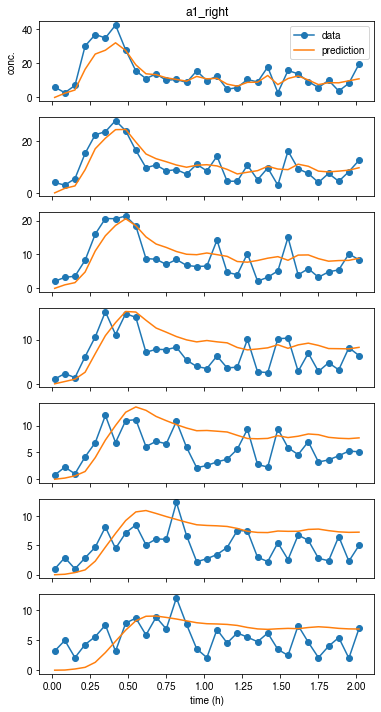

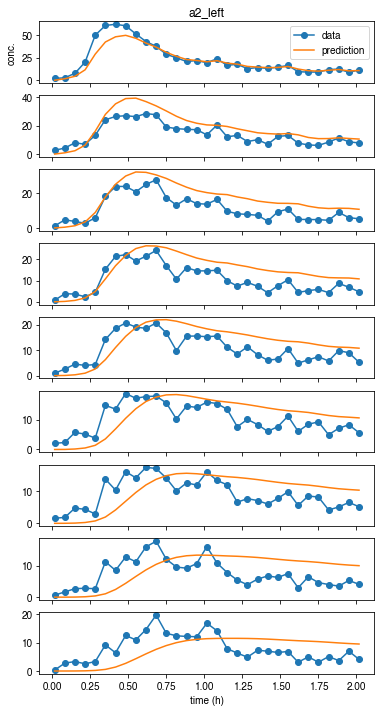

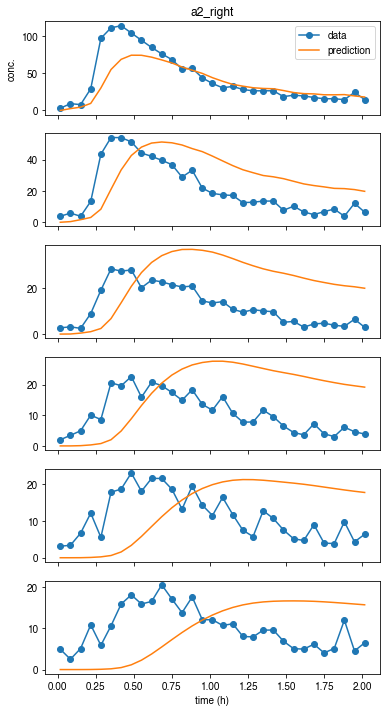

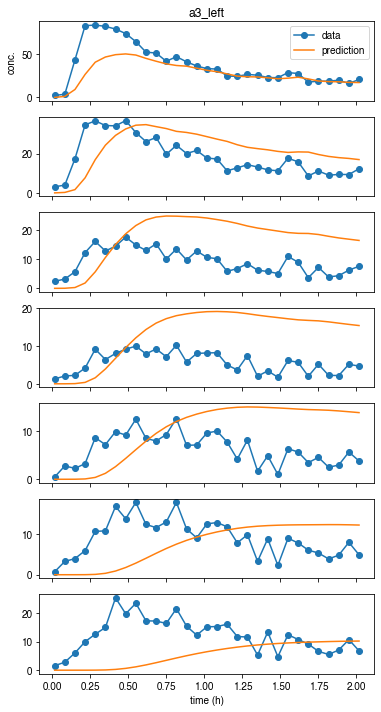

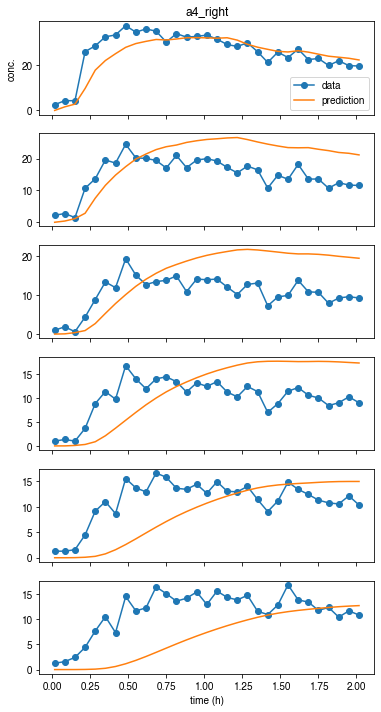

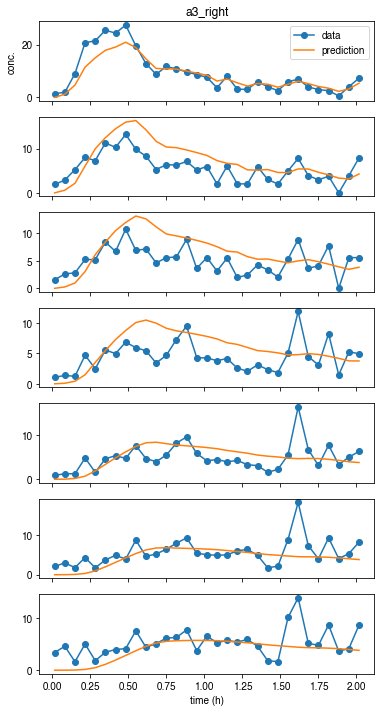

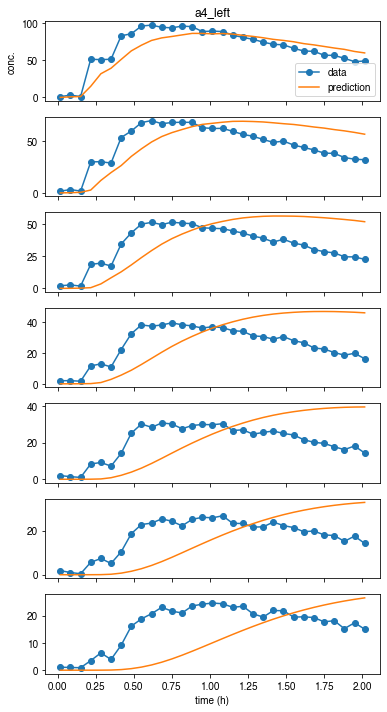

In [379]:
for ID, D in zip(resultsdf["ID"], resultsdf["D"]):
    plot_compare_data_prediction(parseddatafolder + ID + '/', ID, D, 4, f'{resultsfolder}/fitplots/{ID}.png')
    